In [95]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score

#### Basic EDA

In [2]:
# load dataset and display the first 5 rows
data= pd.read_csv("ai_assistant_usage_student_life.csv")
data.head()

,SessionID,StudentLevel,Discipline,SessionDate,SessionLengthMin,TotalPrompts,TaskType,AI_AssistanceLevel,FinalOutcome,UsedAgain,SatisfactionRating
0,SESSION00001,Undergraduate,Computer Science,2024-11-03,31.20,11,Studying,2,Assignment Completed,True,1.0
1,SESSION00002,Undergraduate,Psychology,2024-08-25,13.09,6,Studying,3,Assignment Completed,True,2.0
2,SESSION00003,Undergraduate,Business,2025-01-12,19.22,5,Coding,3,Assignment Completed,True,3.3
3,SESSION00004,Undergraduate,Computer Science,2025-05-06,3.70,1,Coding,3,Assignment Completed,True,3.5
4,SESSION00005,Undergraduate,Psychology,2025-03-18,28.12,9,Writing,3,Assignment Completed,True,2.9


In [3]:
# dataset shape
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   SessionID           10000 non-null  object 
 1   StudentLevel        10000 non-null  object 
 2   Discipline          10000 non-null  object 
 3   SessionDate         10000 non-null  object 
 4   SessionLengthMin    10000 non-null  float64
 5   TotalPrompts        10000 non-null  int64  
 6   TaskType            10000 non-null  object 
 7   AI_AssistanceLevel  10000 non-null  int64  
 8   FinalOutcome        10000 non-null  object 
 9   UsedAgain           10000 non-null  bool   
 10  SatisfactionRating  10000 non-null  float64
dtypes: bool(1), float64(2), int64(2), object(6)
memory usage: 791.1+ KB


In [4]:
# Display column names and their data types.
print(data.dtypes)

SessionID              object
StudentLevel           object
Discipline             object
SessionDate            object
SessionLengthMin      float64
TotalPrompts            int64
TaskType               object
AI_AssistanceLevel      int64
FinalOutcome           object
UsedAgain                bool
SatisfactionRating    float64
dtype: object


In [5]:
# Check for missing values in each column
data.isnull().sum()

SessionID             0
StudentLevel          0
Discipline            0
SessionDate           0
SessionLengthMin      0
TotalPrompts          0
TaskType              0
AI_AssistanceLevel    0
FinalOutcome          0
UsedAgain             0
SatisfactionRating    0
dtype: int64

In [6]:
# summary statistics for SessionLengthMin and TotalPrompts
data[['SessionLengthMin', 'TotalPrompts']].describe()


,SessionLengthMin,TotalPrompts
count,10000.000000,10000.000000
mean,19.846467,5.607500
std,13.897302,4.648764
min,0.030000,1.000000
25%,9.630000,2.000000
50%,16.650000,4.000000
75%,26.670000,8.000000
max,110.810000,39.000000


In [7]:
# number of unique values in StudentLevel, Discipline, and TaskType
for col in ['StudentLevel', 'Discipline', 'TaskType']:
    print(f"\n{col} - {data[col].nunique()} unique values")
    print(data[col].unique())




StudentLevel - 3 unique values
['Undergraduate' 'Graduate' 'High School']

Discipline - 7 unique values
['Computer Science' 'Psychology' 'Business' 'Biology' 'Math' 'History'
 'Engineering']

TaskType - 6 unique values
['Studying' 'Coding' 'Writing' 'Brainstorming' 'Homework Help' 'Research']


In [8]:
# Which TaskType is the most common?
most_common_task= data['TaskType'].value_counts()
print(most_common_task)
print(f"The most common task has {most_common_task.max()} participants")

TaskType
Writing          3101
Studying         2040
Homework Help    1959
Coding           1948
Brainstorming     476
Research          476
Name: count, dtype: int64
The most common task has 3101 participants


In [9]:
# Calculate the average SessionLengthMin for each StudentLevel
avg_session = data.groupby('StudentLevel')['SessionLengthMin'].mean()
print(avg_session)


StudentLevel
Graduate         20.252236
High School      20.023740
Undergraduate    19.650943
Name: SessionLengthMin, dtype: float64


#### Visualization

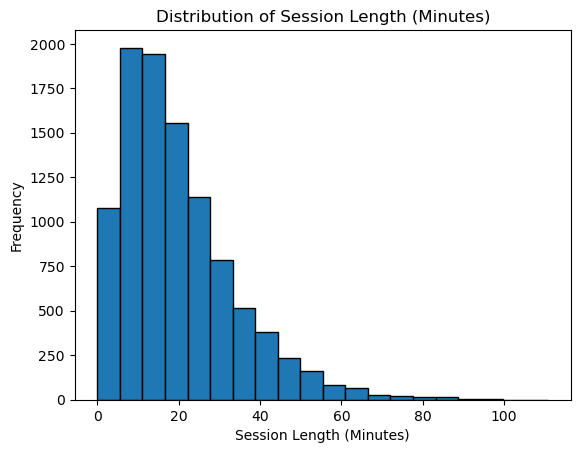

In [11]:
# Plot a histogram of SessionLengthMin
plt.hist(data['SessionLengthMin'], bins=20, edgecolor='black')
plt.title("Distribution of Session Length (Minutes)")
plt.xlabel("Session Length (Minutes)")
plt.ylabel("Frequency")
plt.show()

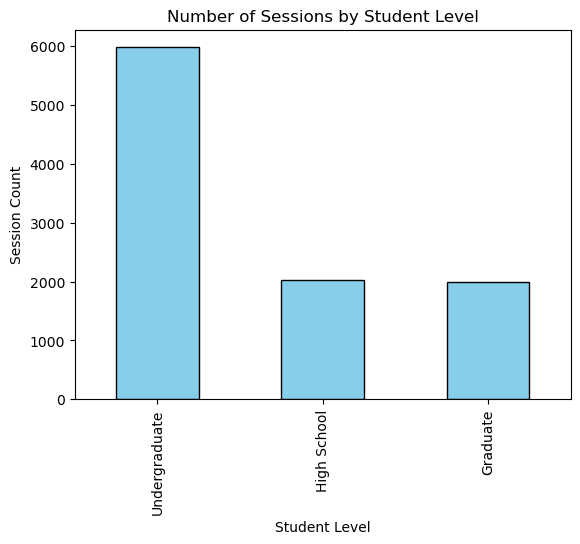

In [12]:
# Create a bar chart of session counts by StudentLevel
session_counts = data['StudentLevel'].value_counts()
session_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Number of Sessions by Student Level")
plt.xlabel("Student Level")
plt.ylabel("Session Count")
plt.show()

C:\Users\pc\AppData\Local\Temp\ipykernel_7856\535356476.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='TaskType', data=data, palette='viridis')


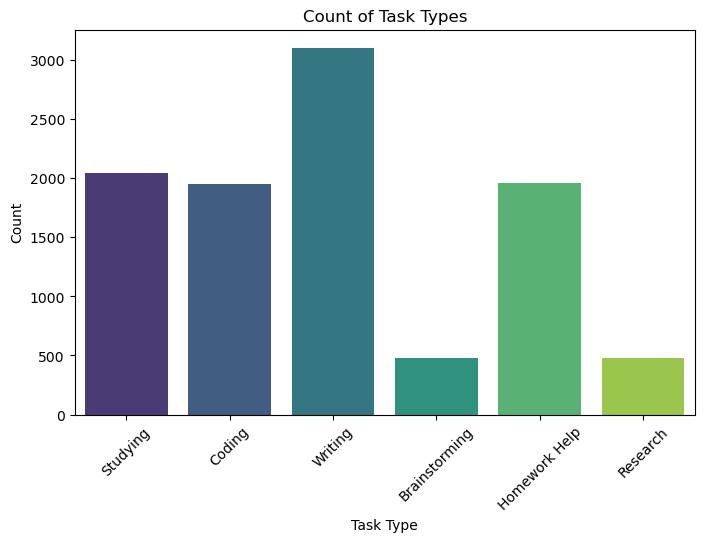

In [ ]:
# Make a countplot of TaskType using Seaborn
plt.figure(figsize=(8,5))
sns.countplot(x='TaskType', data=data, palette='viridis')
plt.title("Count of Task Types")
plt.xlabel("Task Type")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


C:\Users\pc\AppData\Local\Temp\ipykernel_7856\1736990756.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='StudentLevel', y='SessionLengthMin', data=data, palette='Set2')


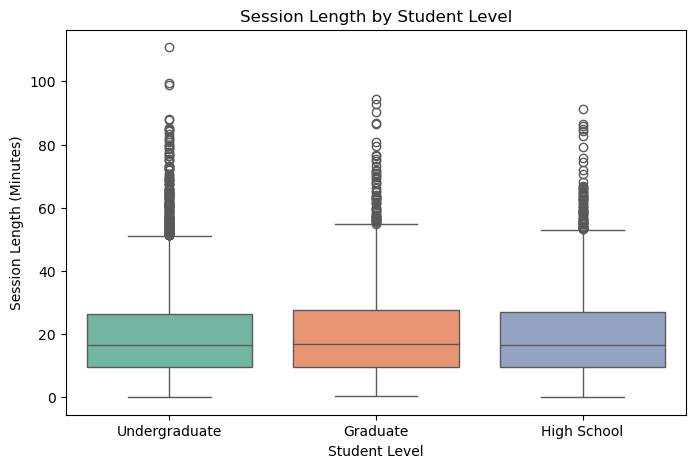

In [16]:
# Plot a boxplot of SessionLengthMin grouped by StudentLevel
plt.figure(figsize=(8,5))
sns.boxplot(x='StudentLevel', y='SessionLengthMin', data=data, palette='Set2')
plt.title("Session Length by Student Level")
plt.xlabel("Student Level")
plt.ylabel("Session Length (Minutes)")
plt.show()

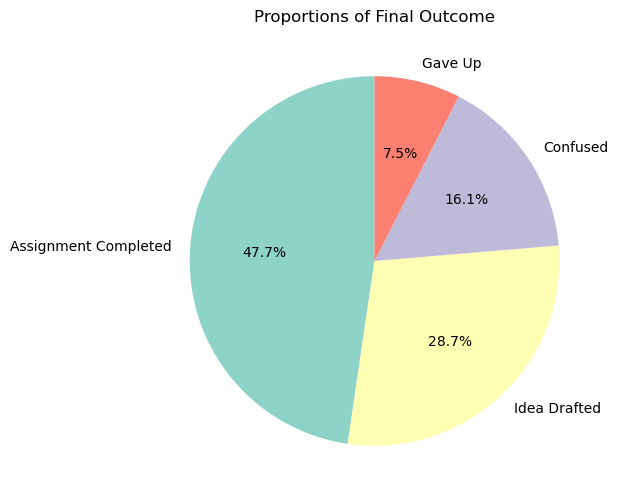

In [17]:
# Create a pie chart showing proportions of FinalOutcome
outcome_counts = data['FinalOutcome'].value_counts()
plt.figure(figsize=(6,6))
plt.pie(outcome_counts, labels=outcome_counts.index, autopct='%1.1f%%', startangle=90, colors=plt.cm.Set3.colors)
plt.title("Proportions of Final Outcome")
plt.show()

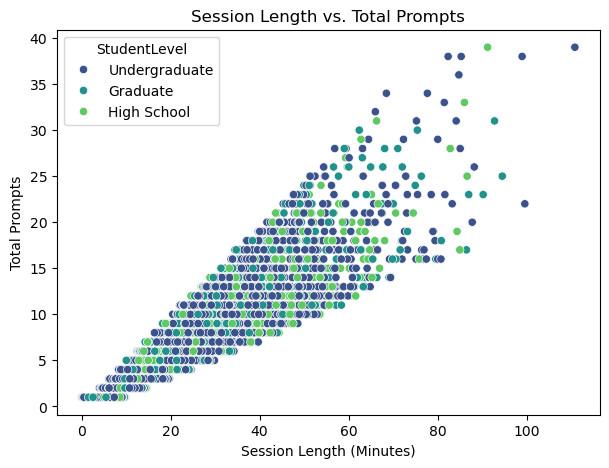

In [19]:
# Draw a scatterplot of SessionLengthMin vs. TotalPrompts
plt.figure(figsize=(7,5))
sns.scatterplot(x='SessionLengthMin', y='TotalPrompts', data=data, hue='StudentLevel', palette='viridis')
plt.title("Session Length vs. Total Prompts")
plt.xlabel("Session Length (Minutes)")
plt.ylabel("Total Prompts")
plt.show()

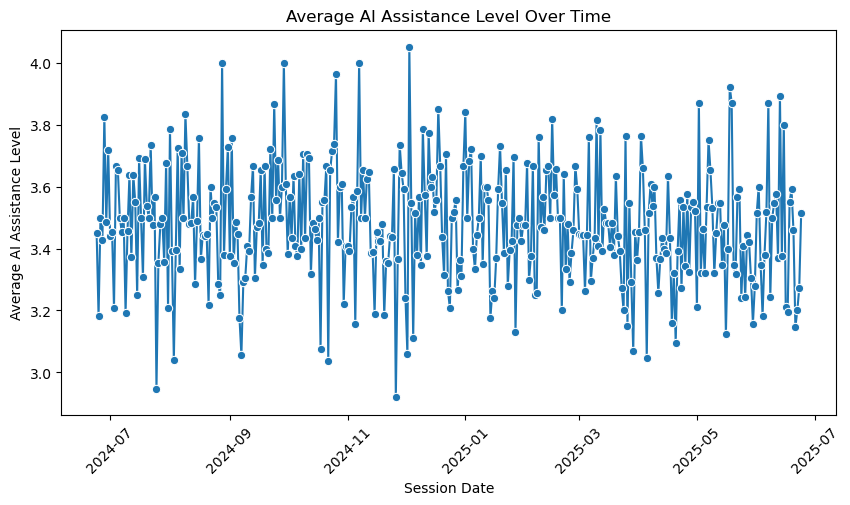

In [20]:
# Plot a line chart of average AI_AssistanceLevel over time (SessionDate)
data['SessionDate'] = pd.to_datetime(data['SessionDate'])
avg_assistance = data.groupby('SessionDate')['AI_AssistanceLevel'].mean().reset_index()
plt.figure(figsize=(10,5))
sns.lineplot(x='SessionDate', y='AI_AssistanceLevel', data=avg_assistance, marker='o')

plt.title("Average AI Assistance Level Over Time")
plt.xlabel("Session Date")
plt.ylabel("Average AI Assistance Level")
plt.xticks(rotation=45) 
plt.show()

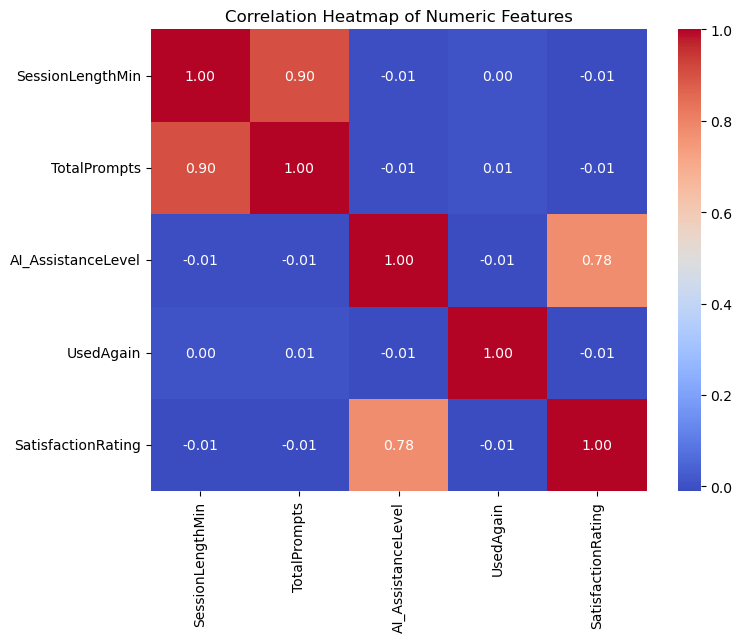

In [21]:
# Create a heatmap of correlations among numeric features
corr = data.corr(numeric_only=True)
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.show()

#### GroupBy & Aggregations

In [23]:
#Find the average SessionLengthMin for each TaskType
avg_session_task = data.groupby('TaskType')['SessionLengthMin'].mean()
print(avg_session_task)

TaskType
Brainstorming    21.964223
Coding           19.467659
Homework Help    19.940536
Research         20.410000
Studying         19.705917
Writing          19.705888
Name: SessionLengthMin, dtype: float64


In [25]:
# Which Discipline had the most sessions?
discipline_counts = data['Discipline'].value_counts()
most_common_discipline = discipline_counts.idxmax()
session_count = discipline_counts.max()
print("Most common Discipline:", most_common_discipline)
print("Number of sessions:", session_count)
print(f"The Discipline with the most sessions is '{most_common_discipline}' with {session_count} sessions.")

Most common Discipline: Biology
Number of sessions: 1458
The Discipline with the most sessions is 'Biology' with 1458 sessions.


In [27]:
# Compare average AI_AssistanceLevel across StudentLevel
avg_assist = data.groupby('StudentLevel')['AI_AssistanceLevel'].mean()
print(avg_assist)

StudentLevel
Graduate         3.469674
High School      3.477060
Undergraduate    3.483607
Name: AI_AssistanceLevel, dtype: float64


In [29]:
# Find the most common FinalOutcome for Graduate students
graduates = data[data['StudentLevel'] == 'Graduate']
most_common_outcome = graduates['FinalOutcome'].value_counts().idxmax()
outcome_count = graduates['FinalOutcome'].value_counts().max()
print(f"The most common FinalOutcome for Graduate students is '{most_common_outcome}' with {outcome_count} students.")


The most common FinalOutcome for Graduate students is 'Assignment Completed' with 936 students.


In [31]:
# Calculate the median SessionLengthMin for each FinalOutcome
median_session = data.groupby('FinalOutcome')['SessionLengthMin'].median()
print(median_session)

FinalOutcome
Assignment Completed    16.570
Confused                16.040
Gave Up                 17.290
Idea Drafted            17.085
Name: SessionLengthMin, dtype: float64


#### Feature Engineering & Encoding

In [32]:
# Convert SessionDate into Year, Month, and Day columns
data['SessionDate'] = pd.to_datetime(data['SessionDate'])

# extract year, month, and day
data['Year'] = data['SessionDate'].dt.year
data['Month'] = data['SessionDate'].dt.month
data['Day'] = data['SessionDate'].dt.day

print(data[['SessionDate', 'Year', 'Month', 'Day']].head())


  SessionDate  Year  Month  Day
0  2024-11-03  2024     11    3
1  2024-08-25  2024      8   25
2  2025-01-12  2025      1   12
3  2025-05-06  2025      5    6
4  2025-03-18  2025      3   18


In [34]:
#Encode StudentLevel using Label Encoding
le = LabelEncoder()
data['StudentLevel_encoded'] = le.fit_transform(data['StudentLevel'])
print(data[['StudentLevel', 'StudentLevel_encoded']].head())

    StudentLevel  StudentLevel_encoded
0  Undergraduate                     2
1  Undergraduate                     2
2  Undergraduate                     2
3  Undergraduate                     2
4  Undergraduate                     2


In [36]:
# Apply One-Hot Encoding to TaskType
tasktype_encoded = pd.get_dummies(data['TaskType'], prefix='TaskType')
data = pd.concat([data, tasktype_encoded], axis=1)
print(data.head())

      SessionID   StudentLevel        Discipline SessionDate  \
0  SESSION00001  Undergraduate  Computer Science  2024-11-03   
1  SESSION00002  Undergraduate        Psychology  2024-08-25   
2  SESSION00003  Undergraduate          Business  2025-01-12   
3  SESSION00004  Undergraduate  Computer Science  2025-05-06   
4  SESSION00005  Undergraduate        Psychology  2025-03-18   

   SessionLengthMin  TotalPrompts  TaskType  AI_AssistanceLevel  \
0             31.20            11  Studying                   2   
1             13.09             6  Studying                   3   
2             19.22             5    Coding                   3   
3              3.70             1    Coding                   3   
4             28.12             9   Writing                   3   

           FinalOutcome  UsedAgain  ...  TaskType_Homework Help  \
0  Assignment Completed       True  ...                   False   
1  Assignment Completed       True  ...                   False   
2  Assignme

In [ ]:
# Create a new feature: PromptsPerMinute = TotalPrompts / SessionLengthMin
data['PromptsPerMinute'] = data['TotalPrompts'] / data['SessionLengthMin']
print(data[['TotalPrompts', 'SessionLengthMin', 'PromptsPerMinute']].head())

   TotalPrompts  SessionLengthMin  PromptsPerMinute
0            11             31.20          0.352564
1             6             13.09          0.458365
2             5             19.22          0.260146
3             1              3.70          0.270270
4             9             28.12          0.320057


In [38]:
# Bin SessionLengthMin into categories: Short, Medium, Long
bins = [0, 20, 40, float('inf')]
labels = ['Short', 'Medium', 'Long']
data['SessionLengthCategory'] = pd.cut(data['SessionLengthMin'], bins=bins, labels=labels, right=False)
print(data[['SessionLengthMin', 'SessionLengthCategory']].head())


   SessionLengthMin SessionLengthCategory
0             31.20                Medium
1             13.09                 Short
2             19.22                 Short
3              3.70                 Short
4             28.12                Medium


#### Machine Learning (Classification Models)

In [ ]:
# Predict FinalOutcome using a Decision Tree Classifier
data['Year'] = data['SessionDate'].dt.year
data['Month'] = data['SessionDate'].dt.month
data['Day'] = data['SessionDate'].dt.day
X = data.drop(columns=['FinalOutcome', 'SessionDate'])
y = data['FinalOutcome']
X = pd.get_dummies(X, drop_first=True)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

Accuracy: 0.407

Classification Report:
                       precision    recall  f1-score   support

Assignment Completed       0.51      0.58      0.54       953
            Confused       0.27      0.23      0.25       323
             Gave Up       0.19      0.15      0.17       151
        Idea Drafted       0.32      0.29      0.31       573

            accuracy                           0.41      2000
           macro avg       0.32      0.31      0.32      2000
        weighted avg       0.39      0.41      0.40      2000



In [ ]:
# Predict UsedAgain using Logistic Regression
X = data.drop(columns=['UsedAgain', 'SessionDate'])
y = data['UsedAgain']
X = pd.get_dummies(X, drop_first=True, dtype=float)
le = LabelEncoder()
y = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
model = LogisticRegression(max_iter=500, solver='liblinear')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7345

Classification Report:
               precision    recall  f1-score   support

           0       0.55      0.48      0.52       587
           1       0.80      0.84      0.82      1413

    accuracy                           0.73      2000
   macro avg       0.68      0.66      0.67      2000
weighted avg       0.73      0.73      0.73      2000



In [ ]:
# Train a Random Forest Classifier to predict FinalOutcome.
X = data.drop(columns=['FinalOutcome', 'SessionDate'])
y = data['FinalOutcome']
X = pd.get_dummies(X, drop_first=True)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.4745

Classification Report:
                       precision    recall  f1-score   support

Assignment Completed       0.50      0.85      0.63       953
            Confused       0.37      0.12      0.18       323
             Gave Up       0.00      0.00      0.00       151
        Idea Drafted       0.35      0.18      0.24       573

            accuracy                           0.47      2000
           macro avg       0.31      0.29      0.26      2000
        weighted avg       0.40      0.47      0.40      2000



In [61]:
#Use KNN (K-Nearest Neighbors) to classify UsedAgain
X = data.drop(columns=['UsedAgain', 'SessionDate'])
y = data['UsedAgain']
X = pd.get_dummies(X, drop_first=True, dtype=float)
le = LabelEncoder()
y = le.fit_transform(y)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42, stratify=y
)
knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report (le.inverse_transform(y_test),
    le.inverse_transform(y_pred)))

Accuracy: 0.7105

Classification Report:
               precision    recall  f1-score   support

       False       0.52      0.21      0.30       587
        True       0.74      0.92      0.82      1413

    accuracy                           0.71      2000
   macro avg       0.63      0.56      0.56      2000
weighted avg       0.67      0.71      0.67      2000



In [ ]:
# Train a Naive Bayes Classifier to predict FinalOutcome
X = data.drop(columns=['FinalOutcome', 'SessionDate'])
y = data['FinalOutcome']
X = pd.get_dummies(X, drop_first=True)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred)
))


Accuracy: 0.0755

Classification Report:
                       precision    recall  f1-score   support

Assignment Completed       0.00      0.00      0.00       953
            Confused       0.00      0.00      0.00       323
             Gave Up       0.08      1.00      0.14       151
        Idea Drafted       0.00      0.00      0.00       573

            accuracy                           0.08      2000
           macro avg       0.02      0.25      0.04      2000
        weighted avg       0.01      0.08      0.01      2000



c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
# Build a Gradient Boosting Classifier for UsedAgain
X = data.drop(columns=['UsedAgain', 'SessionDate'])
y = data['UsedAgain']
X = pd.get_dummies(X, drop_first=True)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = GradientBoostingClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred)
))


Accuracy: 0.743

Classification Report:
               precision    recall  f1-score   support

       False       0.58      0.46      0.51       587
        True       0.79      0.86      0.83      1413

    accuracy                           0.74      2000
   macro avg       0.69      0.66      0.67      2000
weighted avg       0.73      0.74      0.73      2000



In [97]:
#Build a Gradient Boosting Classifier for UsedAgain
X = data.drop(columns=['FinalOutcome', 'SessionDate'])
y = data['FinalOutcome']
X = pd.get_dummies(X, drop_first=True)
le = LabelEncoder()
y = le.fit_transform(y)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(
    le.inverse_transform(y_test),
    le.inverse_transform(y_pred)
))

AttributeError: 'DataFrame' object has no attribute 'dtype'

In [ ]:
# Split the dataset into 80% training and 20% testing sets
X = data.drop(columns=['FinalOutcome'])  # replace FinalOutcome with your target column
y = data['FinalOutcome']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

Accuracy: 0.4745


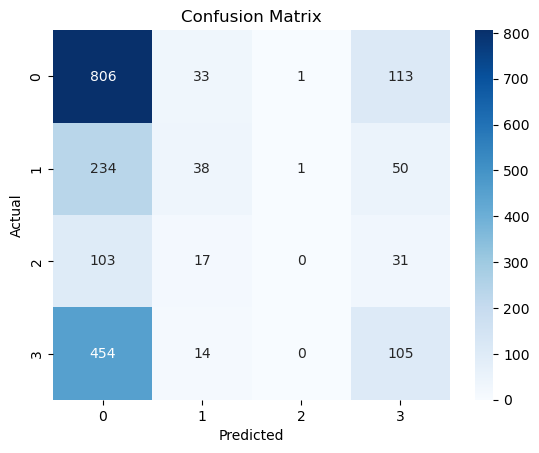

In [ ]:
#Evaluate one model using accuracy and a confusion matrix
X = data.drop(columns=['FinalOutcome', 'SessionDate'])
y = data['FinalOutcome']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [78]:
# Generate a classification report (precision, recall, f1-score)
X = data.drop(columns=['FinalOutcome', 'SessionDate'])
y = data['FinalOutcome']
X = pd.get_dummies(X, drop_first=True)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.4745

Classification Report:
                       precision    recall  f1-score   support

Assignment Completed       0.50      0.85      0.63       953
            Confused       0.37      0.12      0.18       323
             Gave Up       0.00      0.00      0.00       151
        Idea Drafted       0.35      0.18      0.24       573

            accuracy                           0.47      2000
           macro avg       0.31      0.29      0.26      2000
        weighted avg       0.40      0.47      0.40      2000



#### 

#### Model Evaluation & Hyperparameter Tuning

In [87]:
# Perform cross-validation for Logistic Regression
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Logistic Regression with scaled features
model = LogisticRegression(max_iter=2000, solver='lbfgs')

# Cross-validation
scores = cross_val_score(model, X_scaled, y, cv=5, scoring='accuracy')

print("Cross-validation scores:", scores)
print("Mean accuracy:", np.mean(scores))

Cross-validation scores: [0.432  0.4805 0.468  0.4605 0.4675]
Mean accuracy: 0.4617000000000001


In [91]:
# Use GridSearchCV to tune hyperparameters of a Decision Tree
param_grid = {
    'max_depth': [None, 5, 10, 15],     
    'min_samples_split': [2, 5, 10],    
    'min_samples_leaf': [1, 2, 4],  
    'criterion': ['gini', 'entropy']
}
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    estimator=dt,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,       
    verbose=1    
)
grid_search.fit(X_train, y_train)
best_dt = grid_search.best_estimator_
y_pred = best_dt.predict(X_test)
print("Best Parameters:", grid_search.best_params_)
print("Test Accuracy:", accuracy_score(y_test, y_pred))

Fitting 5 folds for each of 72 candidates, totalling 360 fits


KeyboardInterrupt: 

In [92]:
# Tune a Random Forest Classifier (n_estimators, max_depth)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
rf = RandomForestClassifier(random_state=42)
param_grid = {
    'n_estimators': [50, 100, 200], 
    'max_depth': [None, 5, 10, 20]  
}
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,             
    scoring='accuracy',
    n_jobs=-1         
)
grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)
print("\nClassification Report:\n", classification_report(y_test, y_pred))

KeyboardInterrupt: 

In [ ]:
# Compare Logistic Regression, Decision Tree, Random Forest, Naive Bayes, KNN, Gradient Boosting, and XGBoost for predicting UsedAgain
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Naive Bayes": GaussianNB(),
    "KNN": KNeighborsClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}
results = {}
for name, model in models.items():
    if name in ["KNN", "Logistic Regression"]:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    results[name] = acc
    print(f"\n{name}")
    print("Accuracy:", acc)
    print(classification_report(y_test, y_pred))
results_df = pd.DataFrame(list(results.items()), columns=["Model", "Accuracy"])
print("\nModel Comparison:")
print(results_df.sort_values(by="Accuracy", ascending=False))


Logistic Regression
Accuracy: 0.4915
              precision    recall  f1-score   support

           0       0.50      0.95      0.65       953
           1       0.00      0.00      0.00       323
           2       0.00      0.00      0.00       151
           3       0.43      0.13      0.20       573

    accuracy                           0.49      2000
   macro avg       0.23      0.27      0.21      2000
weighted avg       0.36      0.49      0.37      2000



c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Decision Tree
Accuracy: 0.407
              precision    recall  f1-score   support

           0       0.51      0.58      0.54       953
           1       0.27      0.23      0.25       323
           2       0.19      0.15      0.17       151
           3       0.32      0.29      0.31       573

    accuracy                           0.41      2000
   macro avg       0.32      0.31      0.32      2000
weighted avg       0.39      0.41      0.40      2000


Random Forest
Accuracy: 0.4745
              precision    recall  f1-score   support

           0       0.50      0.85      0.63       953
           1       0.37      0.12      0.18       323
           2       0.00      0.00      0.00       151
           3       0.35      0.18      0.24       573

    accuracy                           0.47      2000
   macro avg       0.31      0.29      0.26      2000
weighted avg       0.40      0.47      0.40      2000


Naive Bayes
Accuracy: 0.0755
              precision    recall  f1

c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\pc\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



KNN
Accuracy: 0.461
              precision    recall  f1-score   support

           0       0.49      0.84      0.62       953
           1       0.31      0.10      0.15       323
           2       0.19      0.02      0.04       151
           3       0.34      0.15      0.21       573

    accuracy                           0.46      2000
   macro avg       0.33      0.28      0.25      2000
weighted avg       0.40      0.46      0.38      2000

